# Numeric Simulation of the g2 for a single emitter


In [10]:
import seaborn as sns
import pandas as pd 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d


def emit_photons(n_pulses=1000000000, lifetime=1):
    
    time_bins = np.arange(0,12.5*n_pulses,12.5)

    photons = np.random.exponential(scale=lifetime, size=n_pulses)
    timestamps = photons + time_bins
    
    return timestamps
    
    
def hbt_histogram_from_time(lifetime=1):

    timestamps = emit_photons(lifetime=lifetime)
    
    timestamps = loss_function(timestamps, 0.1)

    # Simulate splitting (randomly)
    beam_splitter = np.random.binomial(1, 0.5, size=timestamps.size).astype(bool)
    a = timestamps[beam_splitter]
    b = timestamps[~beam_splitter]

    A = np.ones([a.size,2])
    A[:,0] = a
    ch1 = pd.DataFrame(A, columns=['times', 'id'])

    B = np.zeros([b.size,2])
    B[:,0] = b
    ch2 = pd.DataFrame(B, columns=['times', 'id'])

    diff = pd.concat([ch1,ch2]).sort_values('times').diff().dropna()
    diff = diff[~(diff['id']==0)]
    differences = diff['times'].multiply(diff['id'])    
    
    return differences


def loss_function(timestamps, transmission):
    
    # Simulate optical loss
    transmitted = np.random.binomial(1, transmission, size=timestamps.size).astype(bool)
    surviving_photons = timestamps[transmitted]
    
    return surviving_photons

def normalized_g2(lifetime, bw=None):
    
    x_norm = np.linspace(-60,60,120)

    diffs = hbt_histogram_from_time(lifetime=lifetime)
    
    fig, ax = plt.subplots(1)
    sns.kdeplot(diffs, shade=True, ax=ax, bw=bw)

    # Extract y values
    y = ax.get_lines()[0].get_ydata()
    y = y/y.max()
    x = ax.get_lines()[0].get_xdata()

    y_norm = np.interp(x_norm, x, y)
        
    output = pd.Series(data=y_norm, index=x_norm, name=lifetime).to_frame()
    plt.close("all")
    
    return output


def find_best_tau(lifetimes, target_g20=0.5, bw=None):
    
    simulated_g20 = np.zeros(len(lifetimes))
        
    for i, lt in enumerate(lifetimes):

        g2 = normalized_g2(lt, bw=bw)
        g2.reset_index(inplace=True)
        simulated_g20[i] = g2.iloc[(g2['index'] - 0).abs().argsort()[0],1]
        
    # Find tau resulting in a g2o
    idx = np.abs(simulated_g20 - target_g20).argmin()
    
    closest_g2 = simulated_g20[idx]
    closest_lifetime = lifetimes[idx]
    
    return closest_lifetime 

## The time of a photon-emisison follows a negative exponential curve


Text(0.5,1,'Time Series of the emitted photons')

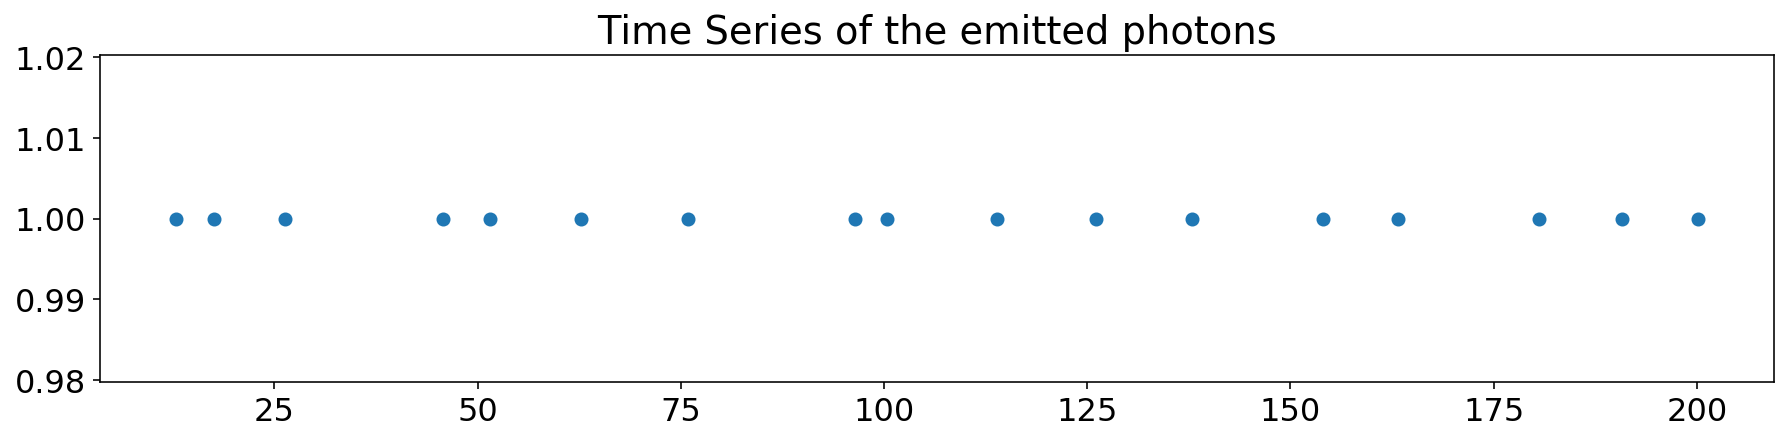

In [11]:
lifetime=2

delayRange = 200
numPulses = int(np.floor(delayRange/12.5)+1)
pulses = np.linspace(0,200, numPulses)

photons = np.random.exponential(scale=lifetime, size=numPulses)
timestamps = np.around(photons,2) + np.around(pulses,2) 

# timestamps
fig, ax = plt.subplots(1, figsize=[15,3])
_ = ax.scatter(timestamps, np.ones(photons.shape[0]))
ax.set_title("Time Series of the emitted photons")


## Find the best lifetime given an observed value of the g2 in tau=0


In [12]:
lifetimes = np.linspace(1, 10, 20)
best_lifetime = find_best_tau(lifetimes, target_g20=0.4, bw=1)
best_lifetime

g2 = normalized_g2(best_lifetime, bw=1)

fig, ax = plt.subplots(1, figsize=[15,8])
g2.plot(ax=ax, legend=False)

_ = ax.set_title(f"g2 for tau best fit ({np.around(best_lifetime, 2)} ns)")
_ = ax.set_xlabel("Relative Delay ns")
_ = ax.set_ylabel("Normalized g2")


MemoryError: 

## See how the g2 would change as a function of lifetime


In [ ]:
df_list = []
for i, lt in enumerate([1, 3, 4, 10]):
    
    g2 = normalized_g2(lt, bw=1)
    df_list.append(g2)
                 
out = pd.concat(df_list, axis=1)


fig, ax = plt.subplots(1,  figsize=[15,8])
out[[10, 4, 3, 1]].plot.area(alpha=0.2, ax=ax, stacked=False)
_ = ax.set_title(f"Simulated g2 vs lifetime")
_ = ax.set_xlabel("Relative Delay ns")
_ = ax.set_ylabel("Normalized g2")
